### Imports

In [229]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [230]:
%autoreload 2

In [231]:
from IPython.display import display
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
from src.vfm.resampler import Resampler
from src.vfm.utils.descriptive_utils import *
from src.vfm.model.hybrid.physics_informed import PhysicsInformedHybridModel
import json

In [232]:
connection = Connection()
# Get client
client = connection.get_client()

In [233]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'gl_mass_rate',
       'gl_open_ratio', 'qo_well_test', 'qg_well_test', 'qw_well_test',
       'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id'],
      dtype='object')

In [234]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [308]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_wells(df=df_all_wells)
len(df_all_wells_preprocessed)

Total original record count 834
W06 original record count: 137
[Non-physical filter] Rows before: 100, dropped: 2 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 1, safety floor (<50.0 Sm3/h): 0), remaining: 98
W06 Record count after preprocessing: 98
W08 original record count: 69
[Non-physical filter] Rows before: 66, dropped: 9 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 0, safety floor (<50.0 Sm3/h): 0), remaining: 57
W08 Record count after preprocessing: 57
W10 original record count: 222
[Non-physical filter] Rows before: 221, dropped: 2 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 1, safety floor (<50.0 Sm3/h): 0), remaining: 219
W10 Record count after preprocessing: 219
W11 original record count: 154
[Non-physical filter] Rows before: 119, dropped: 0 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 0, safety floor (<50.0 Sm3/h): 0), remaining: 119
W11 Record count

725

In [309]:
df_all_wells_preprocessed[df_all_wells_preprocessed["well_id"] == "W18"]["qg_well_test"].describe()

count       81.000000
mean      9711.989692
std       4594.061283
min         71.163799
25%       6442.901700
50%       9636.987035
75%      12160.861631
max      22691.066537
Name: qg_well_test, dtype: float64

In [310]:
summarize_null(df_all_wells_preprocessed)

qo_well_test      0
qg_well_test      0
qw_well_test      0
well_code         0
dhp               0
dht               0
whp               0
wht               0
choke             0
dcp               0
gl_mass_rate      0
gl_open_ratio     0
qo_mpfm          28
qg_mpfm          28
qw_mpfm          28
wc_mpfm           0
gor_mpfm         31
wgr_mpfm         32
gor_well_test     0
wgr_well_test     0
pres_drop         0
temp_drop         0
well_id           0
time_idx          0
dtype: int64

In [311]:
df_all_wells_preprocessed[df_all_wells_preprocessed["well_id"] == "W06"]["qg_well_test"].describe()

count       98.000000
mean     15289.766695
std       4450.432032
min       4808.909153
25%      12326.947029
50%      16413.557469
75%      18801.713901
max      22675.337981
Name: qg_well_test, dtype: float64

In [335]:
df_train, df_val, df_test = get_temporal_split_per_well(df=df_all_wells_preprocessed, train_frac=0.7)
# df_train, df_val, df_test = get_random_train_val_test_split_per_well_temporal_order(df=df_all_wells_preprocessed)
print(f"Train={len(df_train)}, Validation={len(df_val)}, Test={len(df_test)}")

Train=504, Validation=104, Test=117


In [336]:
well_geometry: dict = None

with open(r"data\well_geometry.json", "r") as f:
    well_geometry = json.load(f)

In [337]:
def assert_model(hybrid_model):
    assert hasattr(hybrid_model, "_ml_feature_columns")
    assert len(hybrid_model._ml_feature_columns) > 0

    # Feature consistency check
    df_test_lag = hybrid_model._create_lagged_features(df_test).dropna()
    phys_test = hybrid_model.predict_physics(df_test_lag)

    # Feature consistency check
    X_test_df = hybrid_model._build_ml_features(df_test_lag, phys_test)
    assert list(X_test_df[hybrid_model._ml_feature_columns].columns) == hybrid_model._ml_feature_columns

In [338]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model.fit(df=df_train, df_val=df_val)
assert_model(model)

In [339]:
physics_scores = model.score_physics(df_test)
physics_scores

{'W06': {'qo': {'r2': 0.6629784768640334,
   'mae': 17.863117388068186,
   'rmse': 21.74252541331638,
   'mape (%)': 22.36524508968601,
   'mpe (%)': 22.26091533925811},
  'qw': {'r2': -0.5650694245929961,
   'mae': 1.488260384094561,
   'rmse': 1.7308679185460527,
   'mape (%)': 186.8999106286193,
   'mpe (%)': 110.52750273334621},
  'qg': {'r2': 0.679484783784273,
   'mae': 2188.299546984834,
   'rmse': 2597.777953272364,
   'mape (%)': 14.54431968405695,
   'mpe (%)': -6.735887551366837},
  'wgr': {'r2': -0.9100625166094425,
   'mae': 0.00010611793406797385,
   'rmse': 0.00013303740889281654,
   'mape (%)': 213.39739135791066,
   'mpe (%)': 146.5979799210821},
  'gor': {'r2': -154.25775245123427,
   'mae': 26.978809669352195,
   'rmse': 30.869399666510358,
   'mape (%)': 21.973813078614207,
   'mpe (%)': -21.973813078614207}},
 'W08': {'qo': {'r2': -0.5992912454562325,
   'mae': 12.304540455490601,
   'rmse': 14.30140729778443,
   'mape (%)': 62.230932610872024,
   'mpe (%)': 39.205

In [340]:
hybrid_scores = model.score_hybrid(df_test)
hybrid_scores

{'W06': {'qo': {'r2': 0.9658002484279976,
   'mae': 5.422087653674614,
   'rmse': 6.926161971753836,
   'mape (%)': 6.191707773929052,
   'mpe (%)': -3.124517672560001},
  'qw': {'r2': -1.769352048866157,
   'mae': 1.871631487073885,
   'rmse': 2.3024287995690544,
   'mape (%)': 141.17263841619226,
   'mpe (%)': 13.818671513998886},
  'qg': {'r2': 0.8944996508762291,
   'mae': 1370.3025418623233,
   'rmse': 1490.4062018140064,
   'mape (%)': 11.030303156902372,
   'mpe (%)': -1.2060781310211452},
  'wgr': {'r2': -2.0216889014561836,
   'mae': 0.00013946442405209607,
   'rmse': 0.00016733040471369432,
   'mape (%)': 174.60701100659065,
   'mpe (%)': 47.67290653867652},
  'gor': {'r2': -15.959924846148176,
   'mae': 8.531273640175016,
   'rmse': 10.202661966118248,
   'mape (%)': 6.961805303294858,
   'mpe (%)': 1.798614525861929}},
 'W08': {'qo': {'r2': -26.981236440533976,
   'mae': 56.24311849954383,
   'rmse': 59.820280622547195,
   'mape (%)': 347.8568023927786,
   'mpe (%)': 347.85

In [341]:
mpfm_scores = model.score_mpfm(df=df_test)
mpfm_scores

{'W06': {'qo': {'r2': 0.9958833702162075,
   'mae': 1.955125768976997,
   'rmse': 2.402990610168661,
   'mape (%)': 1.4433757266960396,
   'mpe (%)': 1.1490499350302674},
  'qw': {'r2': -1.6212977654250071,
   'mae': 1.8711558593747482,
   'rmse': 2.240037575646813,
   'mape (%)': 72.57134067217332,
   'mpe (%)': -72.57134067217332},
  'qg': {'r2': 0.9924766203320056,
   'mae': 368.69227901135577,
   'rmse': 398.0010246787303,
   'mape (%)': 2.4224262987763185,
   'mpe (%)': 2.4224262987763185},
  'wgr': {'r2': -1.475919375476669,
   'mae': 0.00012664662976273998,
   'rmse': 0.0001514670740187331,
   'mape (%)': 73.1830525149895,
   'mpe (%)': -73.1830525149895},
  'gor': {'r2': 0.40507371494494837,
   'mae': 1.564540438633201,
   'rmse': 1.9108786794487067,
   'mape (%)': 1.2765714279572484,
   'mpe (%)': 1.2687968872828785}},
 'W08': {'qo': {'r2': 0.8485130822903807,
   'mae': 3.911028129133723,
   'rmse': 4.401518787505579,
   'mape (%)': 22.98942572175901,
   'mpe (%)': -5.13368445

In [342]:
# df_physics = scores_to_df(physics_scores, "Physics")
# df_hybrid  = scores_to_df(hybrid_scores,  "Hybrid")
# df_mpfm    = scores_to_df(mpfm_scores,    "MPFM")

# df_all = pd.concat([df_physics, df_hybrid, df_mpfm], ignore_index=False)

# for well in get_all_wells():
#     df_display = df_all[(df_all["well_id"] == well) & (df_all["metric"] == "r2") & (df_all["variable"].isin(["qg", "qo", "qw"]))]
#     print(df_display[["well_id", "variable", "model", "metric", "value"]].reset_index(drop=True))
    # display(
    # df_display
    # .sort_values(["well_id", "variable"])
    # )

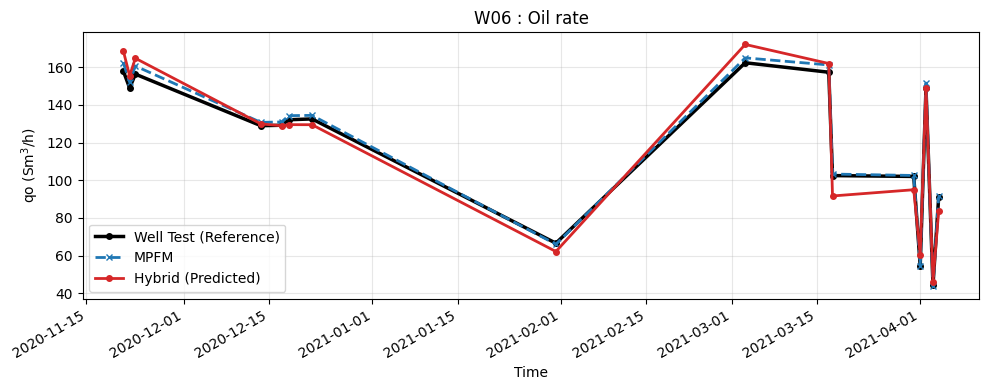

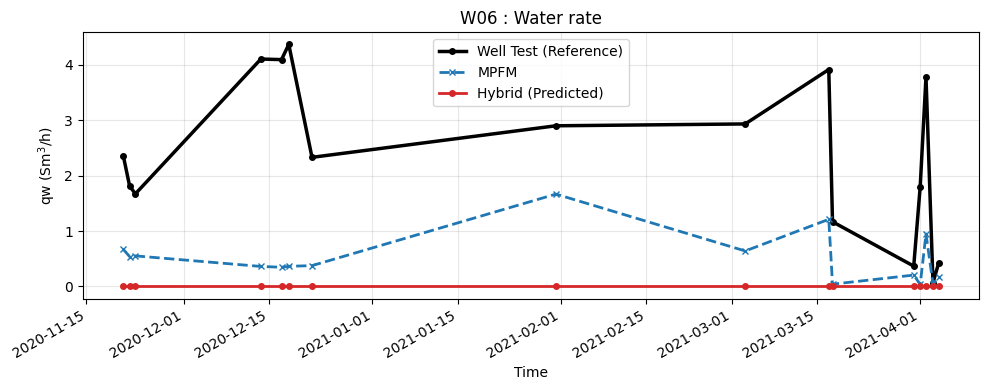

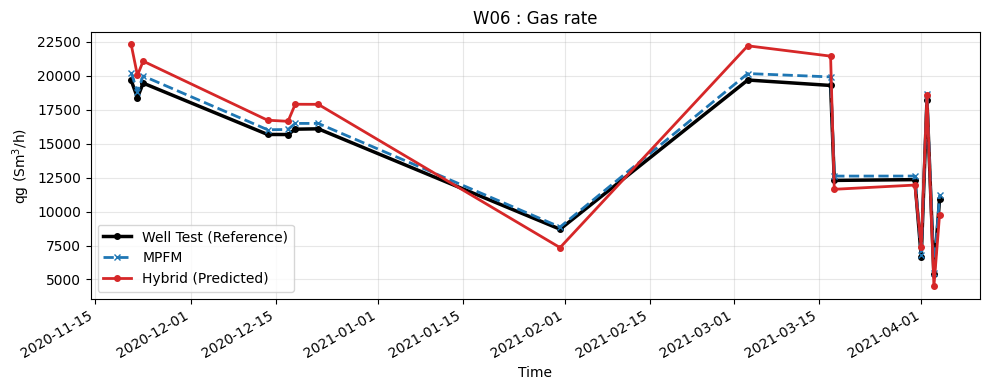

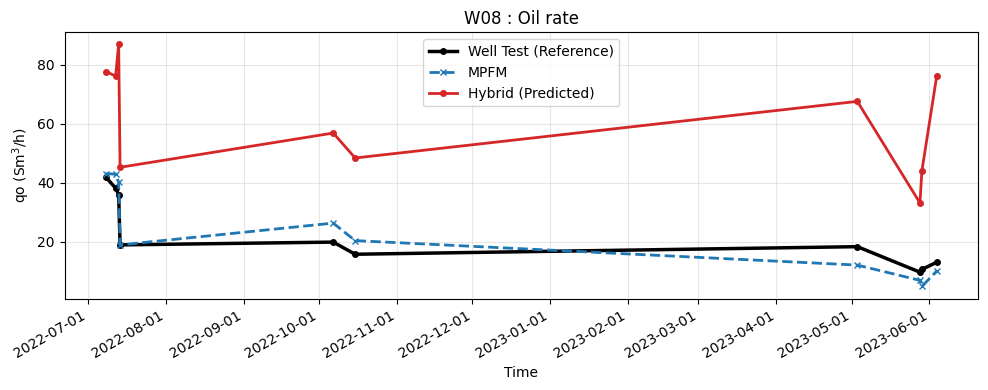

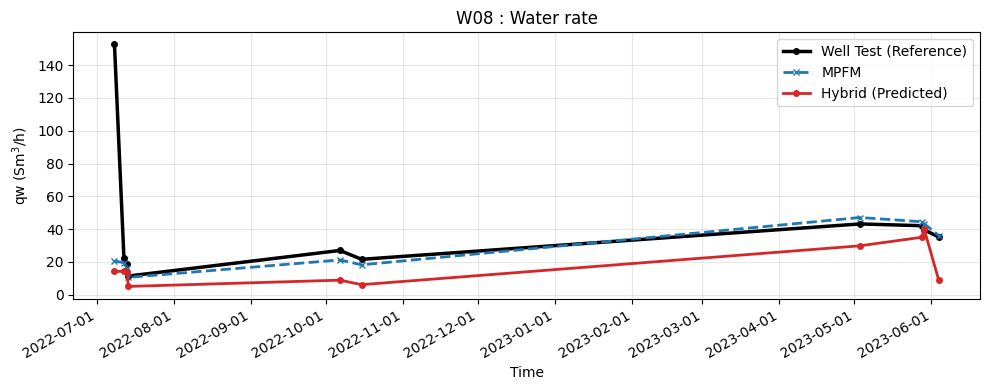

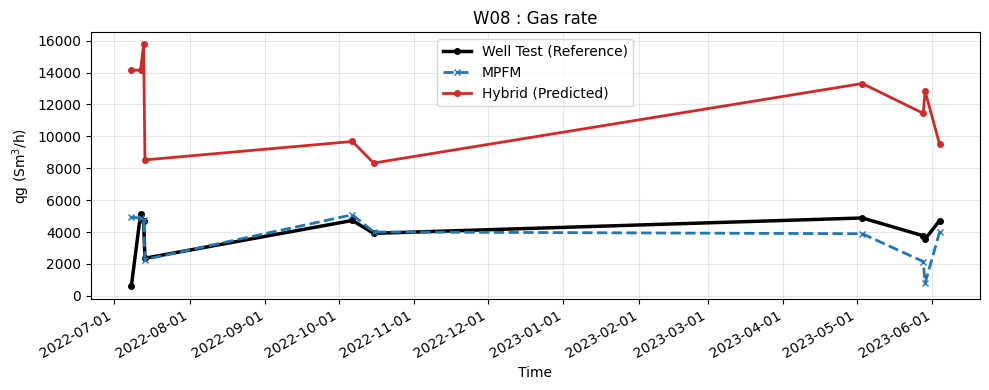

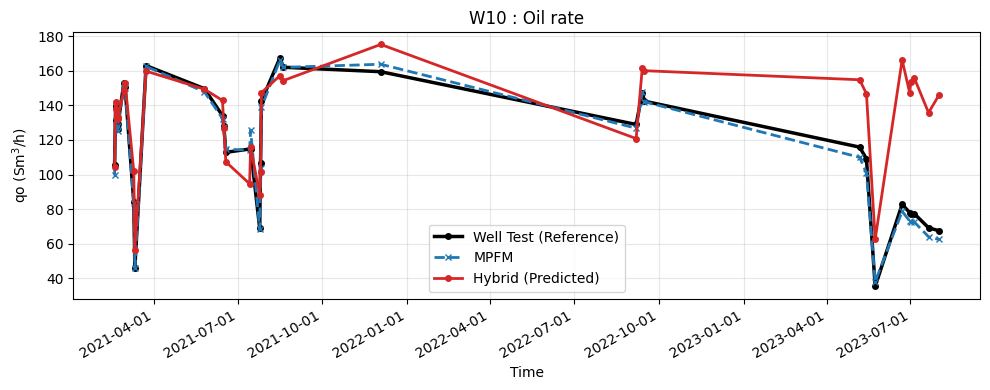

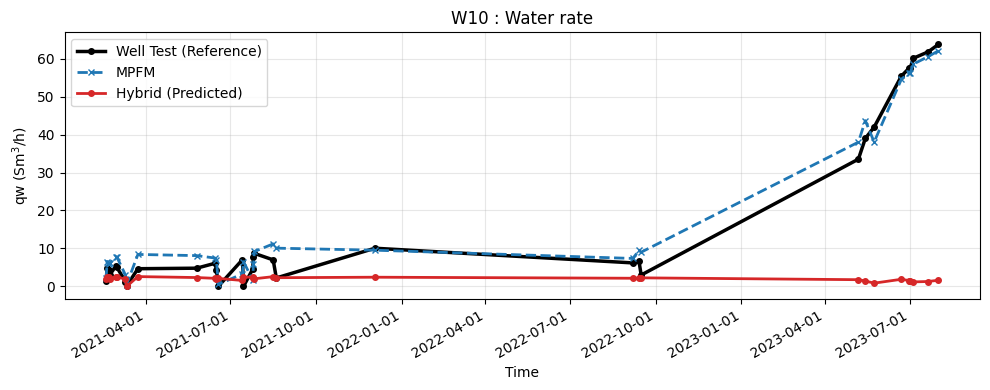

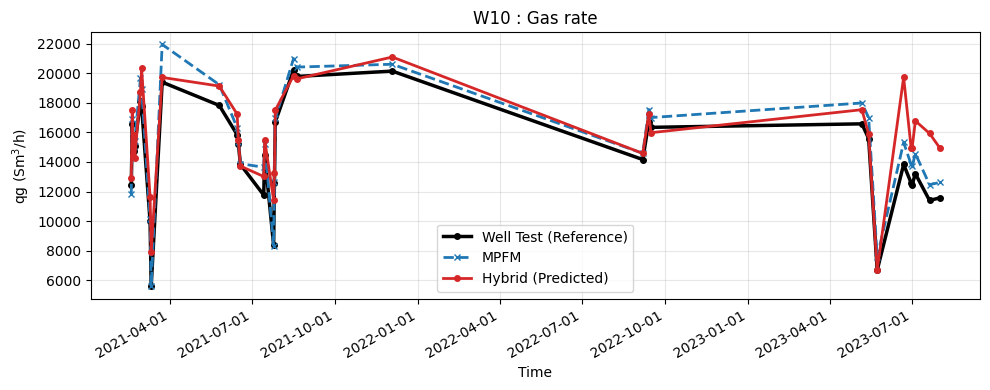

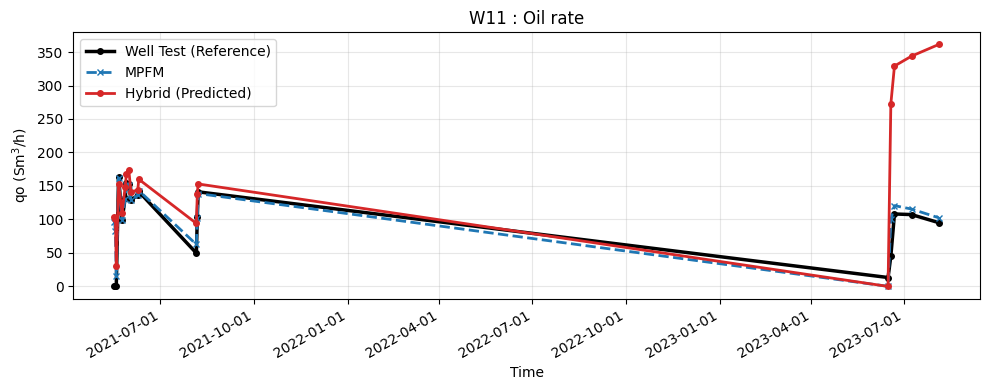

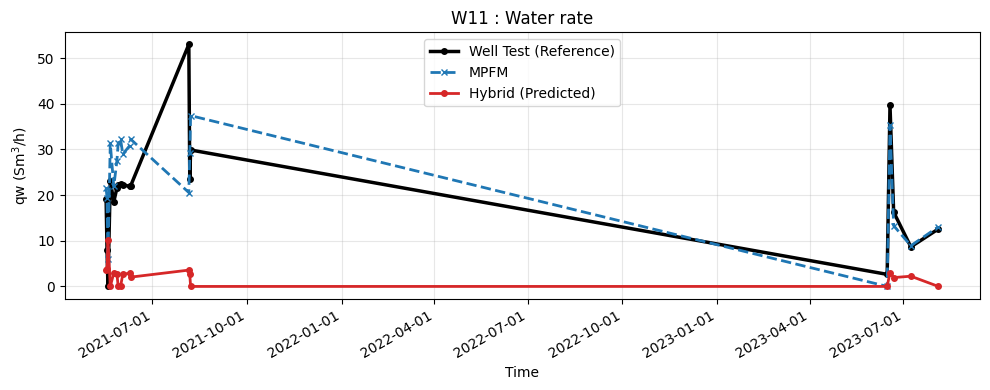

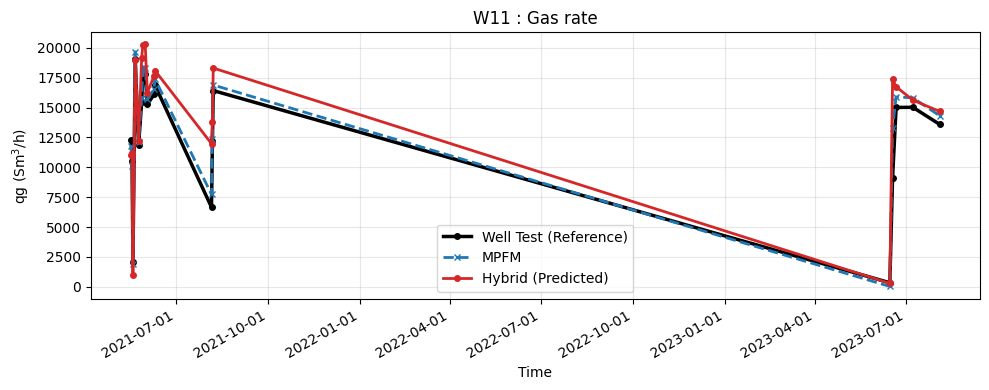

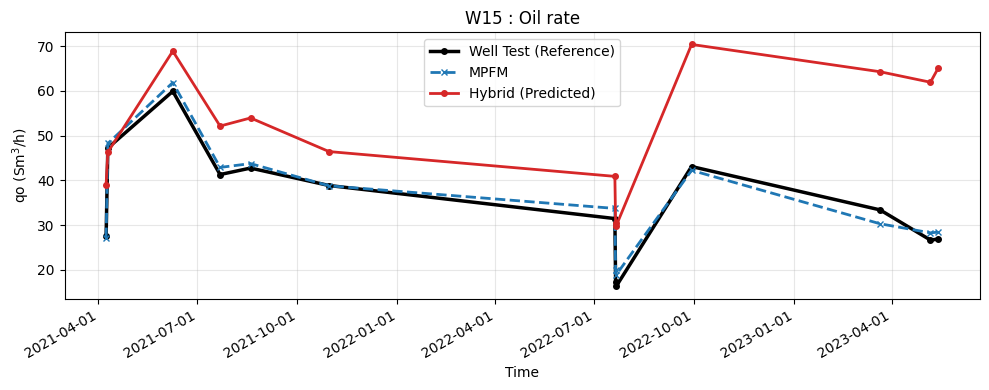

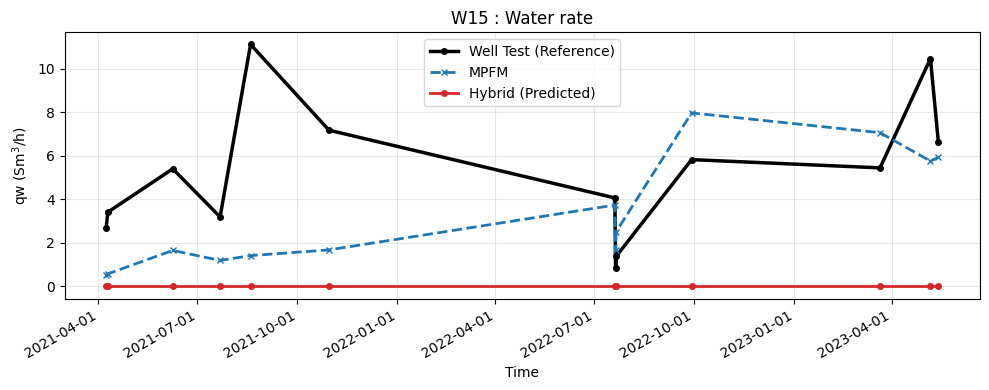

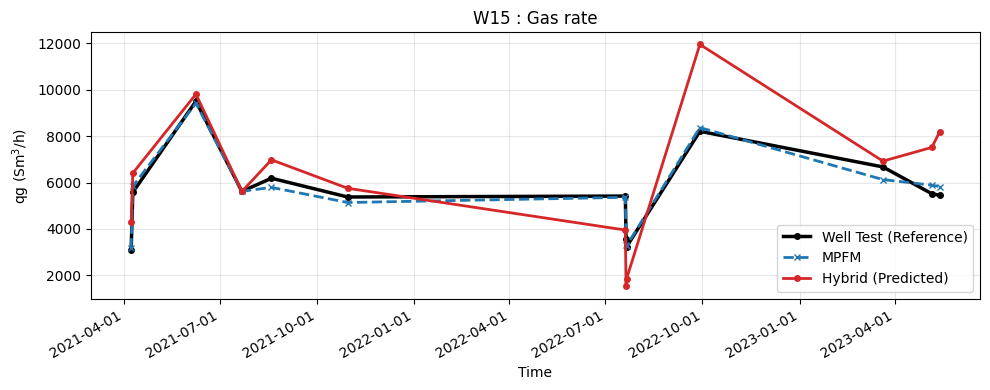

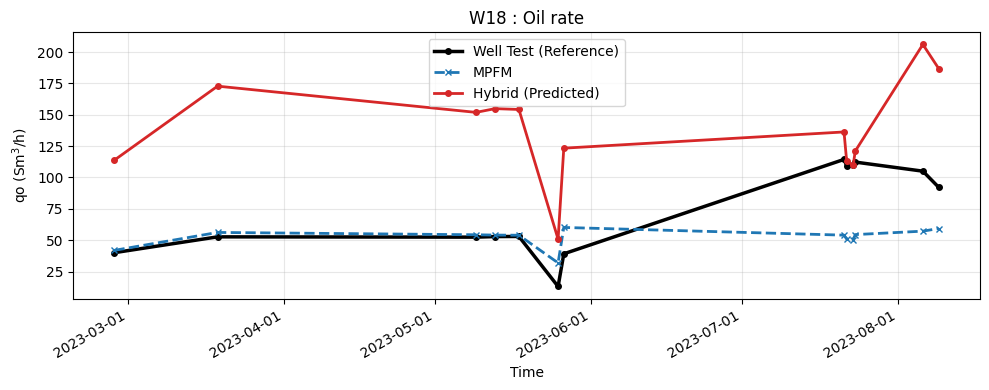

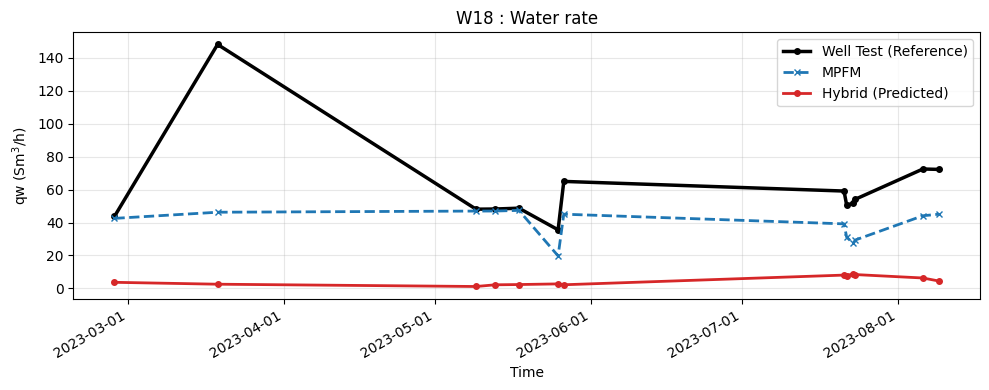

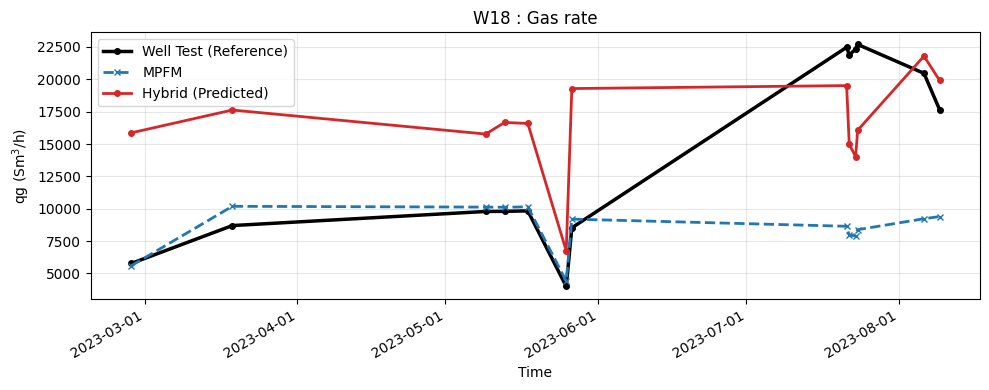

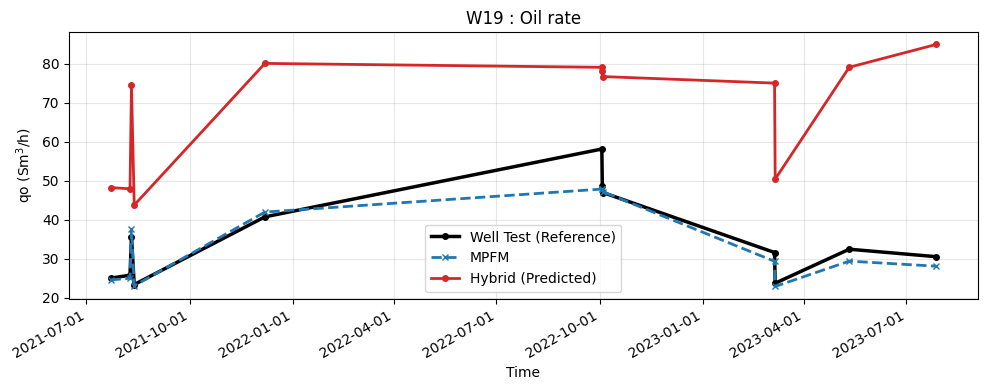

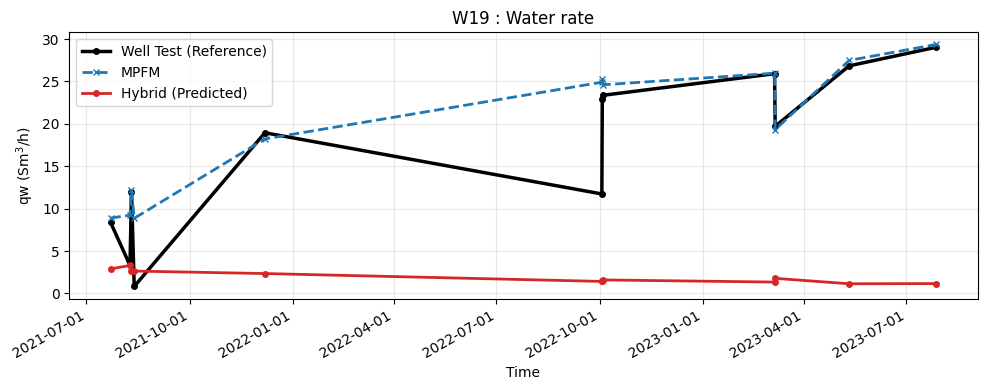

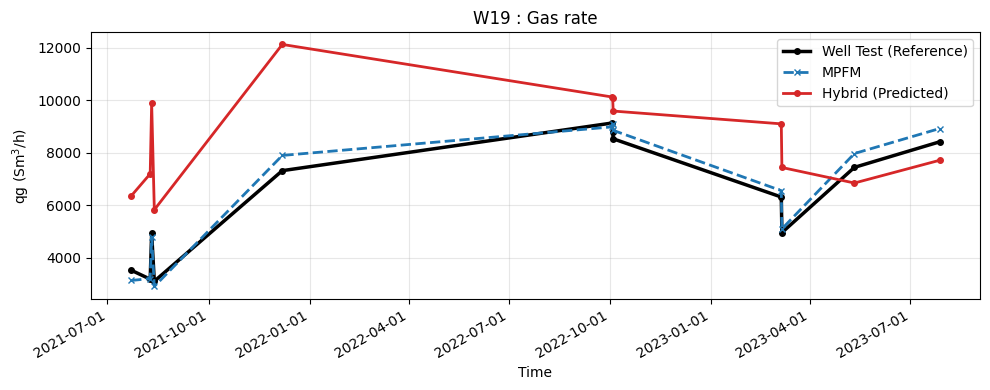

In [343]:
model.plot_predictions(df=df_test, is_hybrid_model=True)

### LOWO test

In [344]:
df_train_lowo, df_val_lowo, df_calibration_lowo, df_test_lowo = get_lowo_train_val_test_split(df=df_all_wells_preprocessed, test_well_id="W10")
print(f"Train={len(df_train_lowo)}, Val={len(df_val_lowo)}, Calibration={len(df_calibration_lowo)}, Test={len(df_test_lowo)}")

Train=395, Val=111, Calibration=26, Test=193


In [345]:
model_lowo = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model_lowo.fit(df=df_train_lowo, df_val=df_val_lowo)

In [346]:
model_lowo.calibrate_physics_only(df=df_calibration_lowo)
assert_model(model_lowo)

In [347]:
model_lowo.score_physics(df_test_lowo)

{'W10': {'qo': {'r2': 0.16821238184694554,
   'mae': 16.462528305425085,
   'rmse': 28.615224298787115,
   'mape (%)': 17.59538572483318,
   'mpe (%)': 8.49637049630959},
  'qw': {'r2': 0.08092788802282169,
   'mae': 3.258354611711054,
   'rmse': 10.54595467076166,
   'mape (%)': 53686.39557948494,
   'mpe (%)': 53656.68257445846},
  'qg': {'r2': 0.3700979306161981,
   'mae': 2259.7256263887116,
   'rmse': 3034.596448811161,
   'mape (%)': 14.468164960117901,
   'mpe (%)': -5.333881109420245},
  'wgr': {'r2': 0.0019314507015320004,
   'mae': 0.00028448634499180886,
   'rmse': 0.0009651353482611254,
   'mape (%)': 66.77387346045104,
   'mpe (%)': 39.195666749094634},
  'gor': {'r2': -4.650700051227792,
   'mae': 18.128821005131485,
   'rmse': 24.4724174927413,
   'mape (%)': 14.108207477211366,
   'mpe (%)': -9.632385348233388}}}

In [348]:
model_lowo.score_hybrid(df_test_lowo)

{'W10': {'qo': {'r2': 0.5800931194112084,
   'mae': 14.968522146570729,
   'rmse': 20.33140653505186,
   'mape (%)': 13.422229950990566,
   'mpe (%)': 7.392669342321591},
  'qw': {'r2': 0.6160592435691579,
   'mae': 3.0971245054279395,
   'rmse': 6.816213957833857,
   'mape (%)': 72433.4966472793,
   'mpe (%)': 72379.04822778142},
  'qg': {'r2': 0.7653852492372898,
   'mae': 1423.9716916332682,
   'rmse': 1852.0047002817655,
   'mape (%)': 10.25394624997549,
   'mpe (%)': 6.776463501578703},
  'wgr': {'r2': 0.5036485377331008,
   'mae': 0.00025089370459692104,
   'rmse': 0.0006806168388824567,
   'mape (%)': 83.68497524255015,
   'mpe (%)': 25.929560988602724},
  'gor': {'r2': -1.7975807701515971,
   'mae': 11.727671614891543,
   'rmse': 17.219362253051276,
   'mape (%)': 9.200429908945914,
   'mpe (%)': 0.852456019166407}}}

In [349]:
model_lowo.score_mpfm(df=df_test_lowo)

{'W10': {'qo': {'r2': 0.9551114931959718,
   'mae': 4.00305335715486,
   'rmse': 6.681764773977168,
   'mape (%)': 3.3496969735960067,
   'mpe (%)': 1.057896359966782},
  'qw': {'r2': 0.9293032667791545,
   'mae': 2.5007538971465837,
   'rmse': 2.9538314911565138,
   'mape (%)': 92359.3990461749,
   'mpe (%)': 92348.76271731901},
  'qg': {'r2': 0.9521658637739112,
   'mae': 472.95032517978314,
   'rmse': 840.0779333068023,
   'mape (%)': 3.2335053537105245,
   'mpe (%)': 2.3965674559765224},
  'wgr': {'r2': 0.9511544918600652,
   'mae': 0.00016944261260778024,
   'rmse': 0.00021575482049865512,
   'mape (%)': 94.07168027585179,
   'mpe (%)': 82.01933134762733},
  'gor': {'r2': 0.2278823005708417,
   'mae': 6.741319074549336,
   'rmse': 9.13773142575352,
   'mape (%)': 5.247331376559211,
   'mpe (%)': 1.5419425910461206}}}

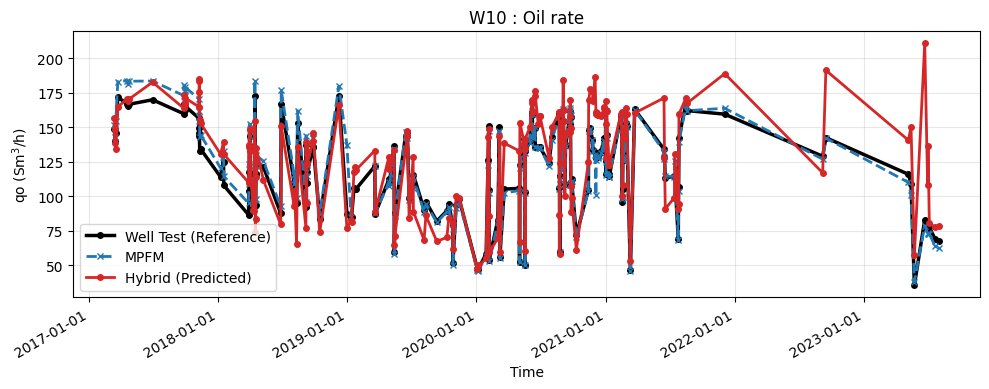

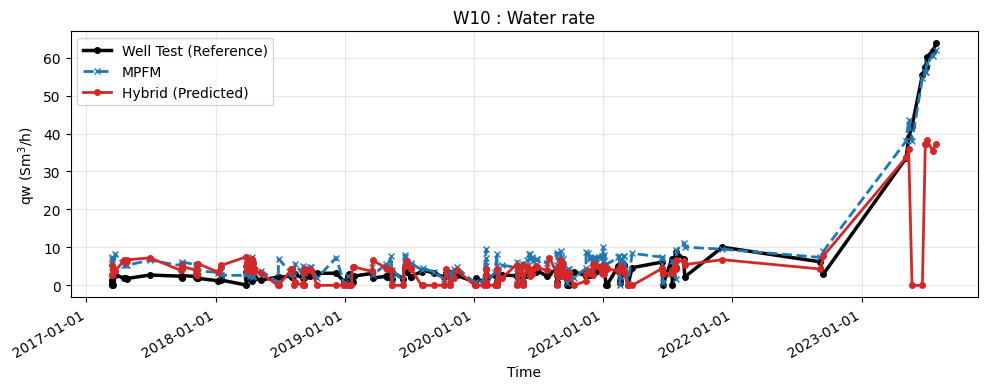

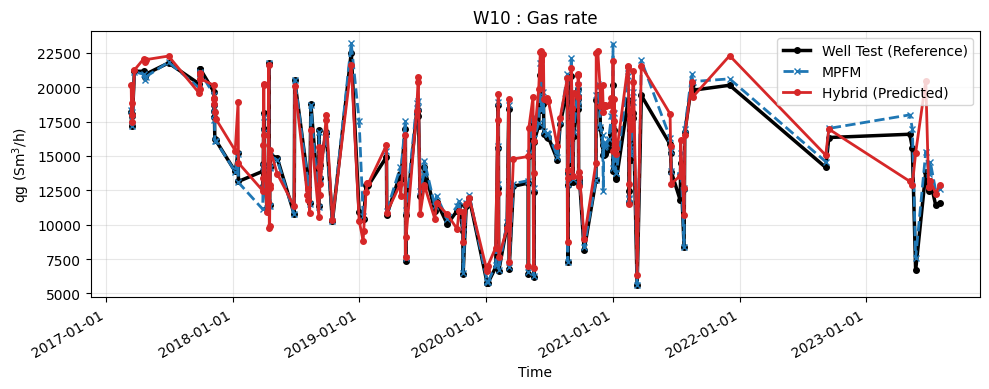

In [350]:
model_lowo.plot_predictions(df=df_test_lowo, model_tag_prefix="lowo")

### Resample and interpolate

In [351]:
# resampler = Resampler()
# df_resampled = resampler.resample_wells(df=df_all_wells_preprocessed, independent_vars=independent_vars)
# print(summarize_null(df=df_resampled))
# print(df_resampled.shape)

In [352]:
# df_resampled.index

In [353]:
# df_resampled.columns

In [354]:
# df_resampled[df_resampled["is_observed"] == 1].shape

In [355]:
# Monotonic
# df_resampled.groupby("well_id")["time_idx"].is_monotonic_increasing

In [356]:
# df_generated = model.generate_dense_well_rates(df=df_resampled)
# df_generated

In [357]:
# summarize_null(df_generated)